In [1]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2023-11-17 11:50:55.277014: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-17 11:50:55.780655: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-17 11:50:56.321133: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-17 11:50:56.344390: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [4]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [5]:
tf.keras.backend.clear_session()

In [6]:
subject = 'Minas Gerais - Consumo de Cimento (t)'
start_index = 0
split_index = 155
window_size = 36
train_split = split_index + 1 - 12

In [7]:
data = pd.read_csv('2003_mo_model_input_MG.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Minas Gerais- custo m2 (R$),Minas Gerais - IDH,Minas Gerais - Consumo de Cimento (t),Minas Gerais - Depósito Poupança (R$),Minas Gerais - IDH Educacao,Minas Gerais - value,Minas Gerais - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Minas Gerais - Produção de Cimento (t),Minas Gerais - Desemprego,Minas Gerais - PIB - Estadual,Minas Gerais - PIB - Construção Civil,Minas Gerais - PIB - Per Capita,Minas Gerais - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Minas Gerais - IDH Longevidade
0,2003-1,10943.259600,0.756537,247.134,2.263741e+07,0.698929,0.334536,0.759345,1.881651,889.396645,1304.196449,18.796583,16.168039,85.634952,0.300000,648.891160,8.242462,2.937752e+08,1.725077e+07,14.096054,2.759117e+08,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.826175
1,2003-2,11044.202677,0.756708,305.708,2.272827e+07,0.699250,0.335670,0.759119,1.872777,889.450610,1289.394416,18.293640,15.115445,83.129710,0.300000,652.396314,8.236470,2.941480e+08,1.726959e+07,14.102603,2.760648e+08,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.826617
2,2003-3,11138.440825,0.756879,284.168,2.281913e+07,0.699571,0.336553,0.758894,1.638997,889.584406,1285.306737,18.099369,14.148246,79.655520,0.300000,655.911573,8.230479,2.945208e+08,1.728841e+07,14.109152,2.762178e+08,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.827060
3,2003-4,11231.690825,0.757050,286.594,2.290999e+07,0.699892,0.336531,0.758669,1.339260,890.048010,1258.400433,17.617245,13.127518,77.295209,0.380914,656.746430,8.224488,2.948935e+08,1.730723e+07,14.115701,2.763709e+08,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.827502
4,2003-5,11322.829101,0.757222,312.455,2.300085e+07,0.700213,0.336406,0.758443,1.204123,890.232394,1261.365893,17.005052,12.074203,74.991327,0.574731,660.114672,8.218497,2.952663e+08,1.732605e+07,14.122250,2.765239e+08,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.827945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,38004.550289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,37962.793190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,37913.793566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,37853.865772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


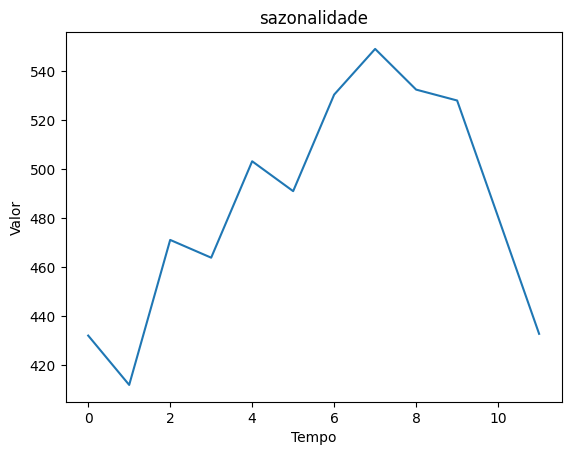

,sazonalidade
sazonalidade,
0,432.008922
1,411.868135
2,471.065437
3,463.809752
4,503.170738
5,490.970226
6,530.379398
7,549.036587
8,532.427237


In [8]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [9]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Minas Gerais- custo m2 (R$),Minas Gerais - IDH,Minas Gerais - Depósito Poupança (R$),Minas Gerais - IDH Educacao,Minas Gerais - value,Minas Gerais - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Minas Gerais - Produção de Cimento (t),Minas Gerais - Desemprego,Minas Gerais - PIB - Estadual,Minas Gerais - PIB - Construção Civil,Minas Gerais - PIB - Per Capita,Minas Gerais - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Minas Gerais - IDH Longevidade,sazonalidade,Minas Gerais - Consumo de Cimento (t)
0,2003-1,10943.259600,0.756537,2.263741e+07,0.698929,0.334536,0.759345,1.881651,889.396645,1304.196449,18.796583,16.168039,85.634952,0.300000,648.891160,8.242462,2.937752e+08,1.725077e+07,14.096054,2.759117e+08,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.826175,432.008922,247.134
1,2003-2,11044.202677,0.756708,2.272827e+07,0.699250,0.335670,0.759119,1.872777,889.450610,1289.394416,18.293640,15.115445,83.129710,0.300000,652.396314,8.236470,2.941480e+08,1.726959e+07,14.102603,2.760648e+08,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.826617,411.868135,305.708
2,2003-3,11138.440825,0.756879,2.281913e+07,0.699571,0.336553,0.758894,1.638997,889.584406,1285.306737,18.099369,14.148246,79.655520,0.300000,655.911573,8.230479,2.945208e+08,1.728841e+07,14.109152,2.762178e+08,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.827060,471.065437,284.168
3,2003-4,11231.690825,0.757050,2.290999e+07,0.699892,0.336531,0.758669,1.339260,890.048010,1258.400433,17.617245,13.127518,77.295209,0.380914,656.746430,8.224488,2.948935e+08,1.730723e+07,14.115701,2.763709e+08,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.827502,463.809752,286.594
4,2003-5,11322.829101,0.757222,2.300085e+07,0.700213,0.336406,0.758443,1.204123,890.232394,1261.365893,17.005052,12.074203,74.991327,0.574731,660.114672,8.218497,2.952663e+08,1.732605e+07,14.122250,2.765239e+08,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.827945,503.170738,312.455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,38004.550289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,503.170738,NaN
245,2023-6,37962.793190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,490.970226,NaN
246,2023-7,37913.793566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530.379398,NaN
247,2023-8,37853.865772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,549.036587,NaN


In [10]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      268.591
1      246.372
2      292.439
3      310.034
4      322.741
        ...   
244        NaN
245        NaN
246        NaN
247        NaN
248        NaN
Name: Minas Gerais - Consumo de Cimento (t), Length: 249, dtype: float64

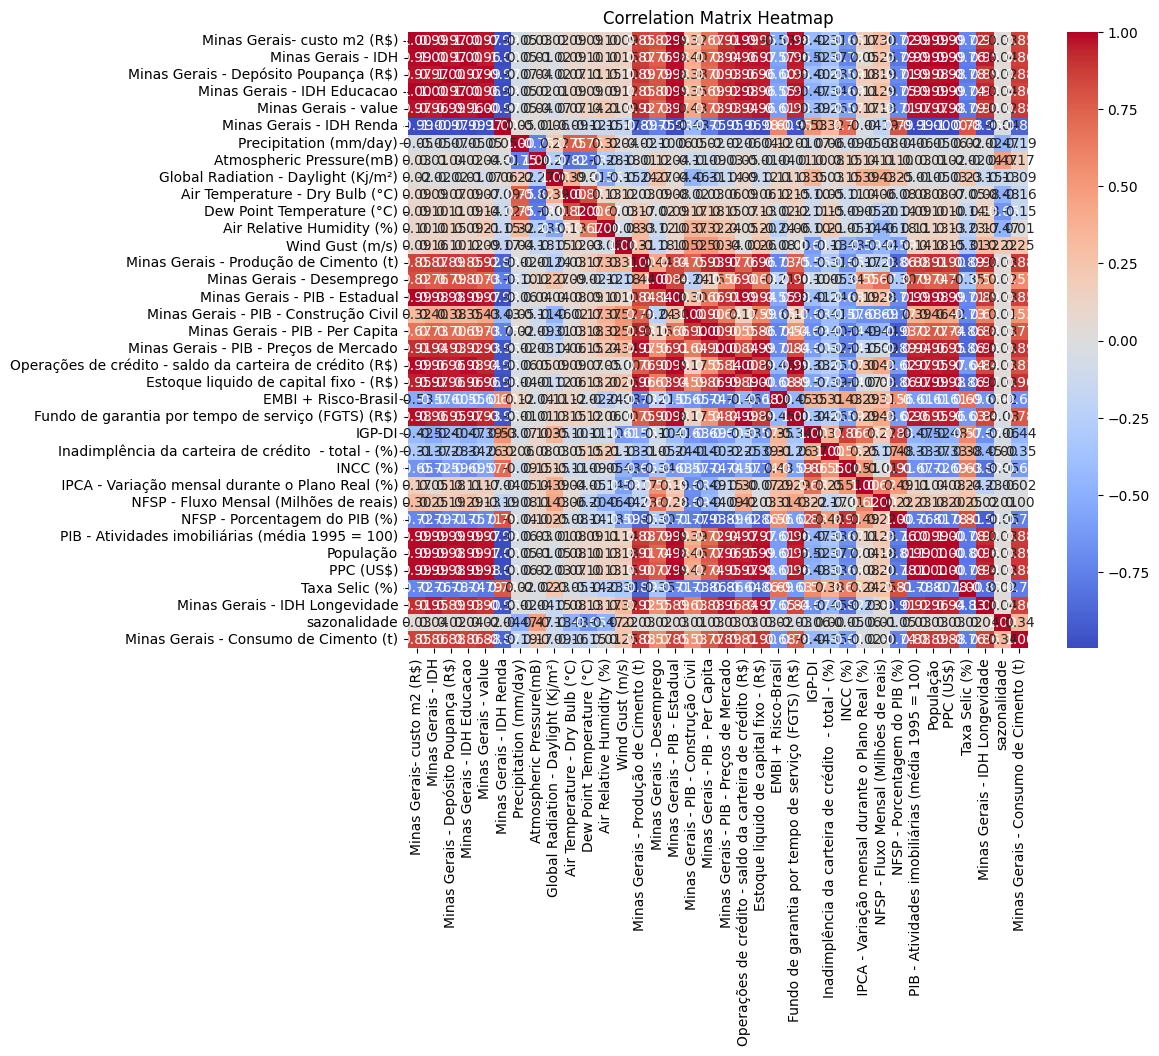

In [11]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [13]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Minas Gerais- custo m2 (R$),2.644313e+06
1,Minas Gerais - IDH,4.809434e+05
2,Minas Gerais - Depósito Poupança (R$),2.287504e+04
3,Minas Gerais - IDH Educacao,2.597069e+06
4,Minas Gerais - value,5.653759e+03
5,Minas Gerais - IDH Renda,2.060316e+05
6,Precipitation (mm/day),7.405005e+00
7,Atmospheric Pressure(mB),2.441600e+01
8,Global Radiation - Daylight (Kj/m²),1.872272e+01
9,Air Temperature - Dry Bulb (°C),1.410443e+03


In [14]:
data =data.drop(['Air Temperature - Dry Bulb (°C)',
                 'Precipitation (mm/day)',
                 'Global Radiation - Daylight (Kj/m²)', 
                 'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 10000000)
data

Num columns removed: 0


,Minas Gerais- custo m2 (R$),Minas Gerais - IDH,Minas Gerais - Depósito Poupança (R$),Minas Gerais - IDH Educacao,Minas Gerais - value,Minas Gerais - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Minas Gerais - Produção de Cimento (t),Minas Gerais - Desemprego,Minas Gerais - PIB - Estadual,Minas Gerais - PIB - Construção Civil,Minas Gerais - PIB - Per Capita,Minas Gerais - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Minas Gerais - IDH Longevidade,sazonalidade
0,10943.259600,0.756537,2.263741e+07,0.698929,0.334536,0.759345,1.881651,889.396645,1304.196449,18.796583,16.168039,85.634952,0.300000,648.891160,8.242462,2.937752e+08,1.725077e+07,14.096054,2.759117e+08,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,0.826175,432.008922
1,11044.202677,0.756708,2.272827e+07,0.699250,0.335670,0.759119,1.872777,889.450610,1289.394416,18.293640,15.115445,83.129710,0.300000,652.396314,8.236470,2.941480e+08,1.726959e+07,14.102603,2.760648e+08,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,0.826617,411.868135
2,11138.440825,0.756879,2.281913e+07,0.699571,0.336553,0.758894,1.638997,889.584406,1285.306737,18.099369,14.148246,79.655520,0.300000,655.911573,8.230479,2.945208e+08,1.728841e+07,14.109152,2.762178e+08,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,0.827060,471.065437
3,11231.690825,0.757050,2.290999e+07,0.699892,0.336531,0.758669,1.339260,890.048010,1258.400433,17.617245,13.127518,77.295209,0.380914,656.746430,8.224488,2.948935e+08,1.730723e+07,14.115701,2.763709e+08,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,0.827502,463.809752
4,11322.829101,0.757222,2.300085e+07,0.700213,0.336406,0.758443,1.204123,890.232394,1261.365893,17.005052,12.074203,74.991327,0.574731,660.114672,8.218497,2.952663e+08,1.732605e+07,14.122250,2.765239e+08,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,0.827945,503.170738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,22852.118460,0.776568,4.522913e+07,0.745561,0.507041,0.733045,1.308080,889.447588,1286.457066,18.703980,13.180216,73.293520,2.072520,1042.262912,10.281388,3.459787e+08,1.768028e+07,14.321018,2.838921e+08,3.143856e+06,7.824899e+06,336.843217,9.124085e+06,0.471500,3.103302,0.501878,0.527374,-1005.696691,2.438647,192.698092,1.969730e+08,390.589413,1.078474,0.857579,549.036587
152,22954.916268,0.776967,4.504128e+07,0.746342,0.506985,0.732495,1.682160,888.802595,1321.808863,19.549474,14.047581,73.534820,2.079398,1040.031184,10.274719,3.461571e+08,1.767042e+07,14.321063,2.838984e+08,3.159665e+06,7.823710e+06,345.939329,9.111628e+06,0.475422,3.177535,0.489257,0.525404,-1039.159506,2.375528,192.754385,1.970500e+08,391.798431,0.962516,0.858522,532.427237
153,23056.977112,0.777365,4.485343e+07,0.747124,0.507113,0.731946,1.833699,888.235364,1338.215229,19.979129,14.846167,74.999272,2.106768,1037.215608,10.268050,3.463356e+08,1.766056e+07

In [15]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Minas Gerais - IDH,Minas Gerais - Depósito Poupança (R$),Minas Gerais - IDH Educacao,Minas Gerais - value,Minas Gerais - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Minas Gerais - Produção de Cimento (t),Minas Gerais - Desemprego,Minas Gerais - PIB - Estadual,Minas Gerais - PIB - Construção Civil,Minas Gerais - PIB - Per Capita,Minas Gerais - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Minas Gerais - IDH Longevidade
0,-1.925540,-1.464043,-1.764742,-1.309837,1.908156,0.631269,0.434953,0.789108,0.174933,1.449442,2.265248,-4.350513,-1.905766,-0.483097,-1.615473,-2.199381,-2.702877,-2.420127,-1.219223,-2.123742,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.960668,-1.737578,2.007617,-2.476492
1,-1.894540,-1.453988,-1.740622,-1.294575,1.878524,0.609678,0.484465,0.624832,-0.295118,0.697876,1.558286,-4.350513,-1.886587,-0.490140,-1.593090,-2.148551,-2.626490,-2.359560,-1.218580,-2.088916,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.929970,-1.724415,1.464013,-2.421444
2,-1.863540,-1.443933,-1.716502,-1.282700,1.848891,0.040859,0.607218,0.579466,-0.476684,0.007282,0.577892,-4.350513,-1.867353,-0.497183,-1.570706,-2.097722,-2.550103,-2.298993,-1.218537,-2.054090,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.899271,-1.710831,2.880457,-2.366396
3,-1.832539,-1.433879,-1.692382,-1.282996,1.819259,-0.688440,1.032560,0.280854,-0.927277,-0.721532,-0.088172,-4.175657,-1.862785,-0.504226,-1.548323,-2.046893,-2.473717,-2.238427,-1.218044,-2.019264,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.868573,-1.696931,1.143128,-2.311348
4,-1.801539,-1.423824,-1.668261,-1.284684,1.789626,-1.017247,1.201726,0.313765,-1.499433,-1.473613,-0.738312,-3.756819,-1.844355,-0.511269,-1.525939,-1.996064,-2.397330,-2.177860,-1.216487,-1.984438,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.837874,-1.683397,1.920025,-2.256299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,1.703831,1.035909,1.739419,1.011138,-1.550623,-0.764306,0.481692,0.592233,0.088386,-0.683905,-1.217422,-0.520094,0.246599,1.913831,1.519104,-1.039286,-0.078885,0.738007,1.823582,0.951535,0.414233,1.659621,-0.661498,-0.418507,-1.258759,0.318154,2.562832,-0.538499,1.326731,1.382734,1.398025,0.209123,1.430142
152,1.775980,1.015122,1.798134,1.010384,-1.622911,0.145880,-0.110067,0.984574,0.878585,-0.064594,-1.149329,-0.505230,0.234388,1.905991,1.529817,-1.065924,-0.078366,0.740524,1.841017,0.944143,0.494098,1.654471,-0.630482,-0.159821,-1.388696,0.293838,2.549126,-0.570093,1.329342,1.395760,1.415152,-0.182135,1.547445
153,1.848129,0.994335,1.856848,1.012110,-1.695199,0.514594,-0.630484,1.166656,1.280140,0.505608,-0.736070,-0.446085,0.218983,1.898151,1.540529,-1.092562,-0.077847,0.743042,1.860456,0.936751,0.584174,1.868895,-0.850517,0.107226,-1.390613,0.251845,2.465341,-0.604269,1.331953,1.408786,1.432633,0.413308,1.664748
154,1.920278,0.973548,1.915563,1.013783,-1.767487,1.338896,-0.940034,1.259267,1.672502,1.017209,-0.418145,-0.641403,0.195650,1.890312,1.551241,-1.119200,-0.077329,0.745560,1.876950,0.929358,0.646687,2.106951,-1.018234,0.372672,-1.421626,0.100243,2.430308,-0.636606,1.327515,1.421813,1.450965,0.074029,1.782050


In [16]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Minas Gerais - IDH,Minas Gerais - Depósito Poupança (R$),Minas Gerais - IDH Educacao,Minas Gerais - value,Minas Gerais - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Minas Gerais - Produção de Cimento (t),Minas Gerais - Desemprego,Minas Gerais - PIB - Estadual,Minas Gerais - PIB - Construção Civil,Minas Gerais - PIB - Per Capita,Minas Gerais - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Minas Gerais - IDH Longevidade
0,-1.925540,-1.464043,-1.764742,-1.309837,1.908156,0.631269,0.434953,0.789108,0.174933,1.449442,2.265248,-4.350513,-1.905766,-0.483097,-1.615473,-2.199381,-2.702877,-2.420127,-1.219223,-2.123742,-0.510608,-1.245444,3.807189,1.508986,3.557039,2.744724,0.791200,4.007134,-1.745295,-1.960668,-1.737578,2.007617,-2.476492
1,-1.894540,-1.453988,-1.740622,-1.294575,1.878524,0.609678,0.484465,0.624832,-0.295118,0.697876,1.558286,-4.350513,-1.886587,-0.490140,-1.593090,-2.148551,-2.626490,-2.359560,-1.218580,-2.088916,-0.710802,-1.285329,3.466444,1.502979,3.362807,2.328463,0.796512,3.841816,-1.739636,-1.929970,-1.724415,1.464013,-2.421444
2,-1.863540,-1.443933,-1.716502,-1.282700,1.848891,0.040859,0.607218,0.579466,-0.476684,0.007282,0.577892,-4.350513,-1.867353,-0.497183,-1.570706,-2.097722,-2.550103,-2.298993,-1.218537,-2.054090,-0.544025,-1.300726,3.304873,1.501477,3.234624,2.074077,0.748042,3.657082,-1.733978,-1.899271,-1.710831,2.880457,-2.366396
3,-1.832539,-1.433879,-1.692382,-1.282996,1.819259,-0.688440,1.032560,0.280854,-0.927277,-0.721532,-0.088172,-4.175657,-1.862785,-0.504226,-1.548323,-2.046893,-2.473717,-2.238427,-1.218044,-2.019264,-0.101360,-1.304485,3.047593,1.499141,3.111793,1.960720,0.637207,3.455390,-1.728320,-1.868573,-1.696931,1.143128,-2.311348
4,-1.801539,-1.423824,-1.668261,-1.284684,1.789626,-1.017247,1.201726,0.313765,-1.499433,-1.473613,-0.738312,-3.756819,-1.844355,-0.511269,-1.525939,-1.996064,-2.397330,-2.177860,-1.216487,-1.984438,0.484338,-1.295677,2.865728,1.487539,3.372081,1.810716,0.681319,3.226068,-1.721344,-1.837874,-1.683397,1.920025,-2.256299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1.176830,1.326966,1.275209,1.219970,-1.061015,0.505832,0.779109,1.482181,-0.788354,-1.806248,-1.976496,-0.144049,0.569799,1.800025,1.382003,-0.593406,0.064237,0.794029,1.517172,1.018624,-0.364905,1.409149,0.519146,-0.961354,-0.690123,1.744343,1.792831,-0.357756,1.345611,1.222749,1.245801,-0.282621,0.652967
140,1.181221,1.297856,1.285850,1.182770,-1.057734,0.202396,0.166353,2.003862,-0.101516,-1.261439,-1.963450,-0.113545,0.540896,1.833762,1.394426,-0.645288,0.034886,0.779300,1.549848,1.015555,-0.347187,1.422197,0.540645,-1.047598,-0.646253,1.739673,1.807843,-0.353467,1.346023,1.236509,1.254608,-0.612121,0.644179
141,1.185613,1.268747,1.296492,1.154894,-1.054452,0.768509,-0.177793,2.484826,0.616388,-0.761980,-2.008248,-0.227356,0.512075,1.867499,1.406849,-0.697171,0.005536,0.764570,1.588878,1.012487,-0.321619,1.608476,0.589758,-1.189483,-0.641003,1.698689,1.374436,-0.355172,1.346436,1.250269,1.263636,-0.137902,0.635390
142,1.190004,1.239637,1.307133,1.128398,-1.051170,1.001397,-0.635012,2.505292,1.104623,-0.079470,-1.544654,-0.460867,0.483097,1.901236,1.419272,-0.749054,-0.023815,0.749841,1.625721,1.009418,-0.287493,1.830253,0.536404,-1.332682,-0.650191,1.675167,1.652790,-0.359681,1.337260,1.264029,1.272935,-0.332143,0.626601


In [17]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      268.591000
1      246.372000
2      292.439000
3      310.034000
4      322.741000
          ...    
139    469.226159
140    455.056087
141    448.499721
142    415.657942
143    404.297000
Name: Minas Gerais - Consumo de Cimento (t), Length: 144, dtype: float64

In [18]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [19]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(108, 36, 33)

In [20]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Minas Gerais - IDH,Minas Gerais - Depósito Poupança (R$),Minas Gerais - IDH Educacao,Minas Gerais - value,Minas Gerais - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Minas Gerais - Produção de Cimento (t),Minas Gerais - Desemprego,Minas Gerais - PIB - Estadual,Minas Gerais - PIB - Construção Civil,Minas Gerais - PIB - Per Capita,Minas Gerais - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),Minas Gerais - IDH Longevidade
108,0.619418,0.744272,0.632995,0.831076,-0.726714,1.780391,-0.650005,0.683724,0.681763,1.341192,1.501413,-0.043580,1.195072,0.490095,0.806455,0.884644,1.075470,1.078497,0.595959,0.890825,-0.758140,0.735654,-0.150121,1.452528,-0.134638,-0.348558,-1.286705,-0.712725,0.693264,0.754385,0.812014,-1.082183,0.761848
109,0.645316,0.792262,0.657958,0.847288,-0.765418,1.002055,-0.180026,0.598616,0.346157,1.124576,1.550311,-0.054479,1.212321,0.535078,0.830025,0.842778,1.043486,1.078432,0.621380,0.900214,-0.744935,0.632719,-0.064049,1.577437,-0.250541,-0.314756,-1.091776,-0.707406,0.732176,0.770574,0.831569,-1.036767,0.762027
110,0.671215,0.840252,0.682922,0.860348,-0.804121,0.862311,0.302470,-0.199082,-0.130105,0.937377,1.863561,-0.178028,1.220604,0.580060,0.853595,0.800911,1.011501,1.078367,0.652999,0.909602,-0.743509,0.633437,0.165323,1.665230,-0.253852,-0.193331,-1.072106,-0.699231,0.771088,0.786763,0.850791,-0.752482,0.762206
111,0.697114,0.888243,0.707885,0.872895,-0.842824,-0.198991,0.859496,-0.533619,-0.736569,0.338306,1.599452,-0.184836,1.207815,0.625043,0.877165,0.759045,0.979517,1.078301,0.685630,0.918990,-0.748471,0.610450,0.155491,1.735648,-0.175858,-0.069191,-1.161345,-0.693507,0.810000,0.802953,0.868783,-1.088413,0.762385
112,0.723012,0.936233,0.732848,0.912713,-0.881527,-0.864385,1.620659,-1.347889,-1.210662,-0.091111,1.499787,-0.066493,1.198758,0.670026,0.900735,0.717178,0.947532,1.078236,0.717515,0.928378,-0.764308,0.631167,-0.075593,1.739412,0.099226,-0.104407,-0.961650,-0.679000,0.850727,0.819142,0.886720,-1.508135,0.762563
113,0.748911,0.984223,0.757812,0.955652,-0.920231,-1.195814,1.706132,-1.509368,-0.637848,-0.232126,0.594672,0.285888,1.182158,0.715008,0.924305,0.675312,0.915547,1.078171,0.747579,0.937766,-0.786416,0.659533,-0.323610,1.747279,-0.153882,-0.083975,-0.938217,-0.662783,0.891455,0.835331,0.905151,-1.474280,0.762742
114,0.774809,1.032214,0.782775,0.973034,-0.958934,-1.109262,1.373373,-0.519737,0.242849,-0.363263,-0.688632,0.802992,1.175710,0.759991,0.947875,0.633445,0.883563,1.078106,0.775262,0.947155,-0.808518,0.667761,-0.525659,1.756575,-0.146871,-0.089130,-0.921820,-0.650682,0.932183,0.851520,0.923702,-1.463452,0.762921
115,0.800708,1.080204,0.807738,1.024634,-0.997637,-0.704829,0.725049,-0.837357,0.767935,0.078518,-0.541280,1.109150,1.153099,0.804974,0.971445,0.591579,0.851578,1.078041,0.805205,0.956543,-0.838953,0.689072,-0.771574,1.787886,-0.265940,-0.124447,-0.813396,-0.648019,0.969967,0.867709,0.942382,-1.236037,0.763100
116,0.826606,1.128194,0.832702,1.068674,-1.036340,0.220661,-0.202579,-0.063632,1.706287,0.562196,-0.926224,1.155681,1.120138,0.849956,0.995015,0.549713,0.819594,1.077976,0.836796,0.965931,-0.869366,0.684945,-0.995926,1.740250,-0.285762,-0.077195,-0.692727,-0.640313,1.007752,0.883899,0.960385,-0.935721,0.763279
117,0.852505,1.176185,0.857665,1.107754,-1.075043,1.211512,-0.788466,0.471309,1.815195,1.092866,-0.197589,0.886836,1.098986,0.894939,1.018586,0.507846,0.787609,1.077911,0.876422,0.975319,-0.900682,0.852584

In [21]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 33)

In [22]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [23]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(144, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [24]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [25]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[1644926377, 1799763746, 4267590660, 4126814470, 178613472, 2233628911, 1379117216, 944970888, 3562669641, 1524117253]


Step: 0 ___________________________________________


2023-11-17 11:50:58.592979: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-17 11:50:58.593166: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-17 11:50:58.593307: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

val_loss: 3772.8994140625
winner_seed: 1644926377


Step: 1 ___________________________________________
val_loss: 1024.458251953125
winner_seed: 1799763746


Step: 2 ___________________________________________
val_loss: 84414016.0


Step: 3 ___________________________________________
val_loss: 2703.895263671875


Step: 4 ___________________________________________
val_loss: 5825554808832.0


Step: 5 ___________________________________________
val_loss: 1.664045221538693e+17


Step: 6 ___________________________________________
val_loss: 1440.38134765625


Step: 7 ___________________________________________
val_loss: 2002.8388671875


Step: 8 ___________________________________________
val_loss: 770.51025390625
winner_seed: 3562669641


Step: 9 ___________________________________________
val_loss: 65272.328125


final_seed: 3562669641


In [26]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 113ms/step - loss: 223233.2344 - val_loss: 41320.4375
Epoch 2/10000
4/4 [==============================] - 0s 8ms/step - loss: 9672.1748 - val_loss: 9437.0557
Epoch 3/10000
4/4 [==============================] - 0s 7ms/step - loss: 7040.2896 - val_loss: 762.6321
Epoch 4/10000
4/4 [==============================] - 0s 7ms/step - loss: 13844.9775 - val_loss: 7883.9448
Epoch 5/10000
4/4 [==============================] - 0s 7ms/step - loss: 7295.5620 - val_loss: 10139.9277
Epoch 6/10000
4/4 [==============================] - 0s 7ms/step - loss: 6819.9058 - val_loss: 8213.9355
Epoch 7/10000
4/4 [==============================] - 0s 7ms/step - loss: 7641.1426 - val_loss: 8279.0889
Epoch 8/10000
4/4 [==============================] - 0s 7ms/step - loss: 7082.1064 - val_loss: 36012.8281
Epoch 9/10000
4/4 [==============================] - 0s 8ms/step - loss: 8999.6426 - val_loss: 1107.2509
Epoch 10/10000
4/4 [============================

Epoch 78/10000
4/4 [==============================] - 0s 7ms/step - loss: 5944.7227 - val_loss: 6253.9624
Epoch 79/10000
4/4 [==============================] - 0s 7ms/step - loss: 6704.8442 - val_loss: 7582.7539
Epoch 80/10000
4/4 [==============================] - 0s 8ms/step - loss: 6795.8745 - val_loss: 6179.5664
Epoch 81/10000
4/4 [==============================] - 0s 7ms/step - loss: 7142.6680 - val_loss: 11458.7217
Epoch 82/10000
4/4 [==============================] - 0s 7ms/step - loss: 6507.1465 - val_loss: 14203.6885
Epoch 83/10000
4/4 [==============================] - 0s 8ms/step - loss: 6627.0537 - val_loss: 23150.9570
Epoch 84/10000
4/4 [==============================] - 0s 7ms/step - loss: 6464.6401 - val_loss: 11772.1514
Epoch 85/10000
4/4 [==============================] - 0s 8ms/step - loss: 6098.1816 - val_loss: 13078.3164
Epoch 86/10000
4/4 [==============================] - 0s 7ms/step - loss: 6110.3169 - val_loss: 16863.1641
Epoch 87/10000
4/4 [====================

4/4 [==============================] - 0s 8ms/step - loss: 6588.2471 - val_loss: 17432.5918
Epoch 155/10000
4/4 [==============================] - 0s 8ms/step - loss: 6621.7852 - val_loss: 9206.0029
Epoch 156/10000
4/4 [==============================] - 0s 7ms/step - loss: 6806.4844 - val_loss: 10885.0391
Epoch 157/10000
4/4 [==============================] - 0s 7ms/step - loss: 6455.2280 - val_loss: 27000.1719
Epoch 158/10000
4/4 [==============================] - 0s 7ms/step - loss: 6692.8677 - val_loss: 7742.6743
Epoch 159/10000
4/4 [==============================] - 0s 7ms/step - loss: 6293.3994 - val_loss: 21042.6094
Epoch 160/10000
4/4 [==============================] - 0s 7ms/step - loss: 6340.5737 - val_loss: 2483.9836
Epoch 161/10000
4/4 [==============================] - 0s 7ms/step - loss: 7629.4590 - val_loss: 19572.2324
Epoch 162/10000
4/4 [==============================] - 0s 7ms/step - loss: 6179.0352 - val_loss: 20221.8574
Epoch 163/10000
4/4 [==========================

4/4 [==============================] - 0s 7ms/step - loss: 5464.5371 - val_loss: 14236.1230
Epoch 231/10000
4/4 [==============================] - 0s 8ms/step - loss: 4482.5244 - val_loss: 2363.1558
Epoch 232/10000
4/4 [==============================] - 0s 7ms/step - loss: 5418.8169 - val_loss: 4754.0630
Epoch 233/10000
4/4 [==============================] - 0s 7ms/step - loss: 4509.7876 - val_loss: 3941.9019
Epoch 234/10000
4/4 [==============================] - 0s 7ms/step - loss: 4501.3413 - val_loss: 12149.0840
Epoch 235/10000
4/4 [==============================] - 0s 7ms/step - loss: 4943.2236 - val_loss: 12809.1172
Epoch 236/10000
4/4 [==============================] - 0s 7ms/step - loss: 4819.3574 - val_loss: 14622.0967
Epoch 237/10000
4/4 [==============================] - 0s 7ms/step - loss: 4801.1899 - val_loss: 13224.3965
Epoch 238/10000
4/4 [==============================] - 0s 8ms/step - loss: 4481.2471 - val_loss: 8892.8896
Epoch 239/10000
4/4 [===========================

4/4 [==============================] - 0s 7ms/step - loss: 5926.4717 - val_loss: 9896.5127
Epoch 307/10000
4/4 [==============================] - 0s 7ms/step - loss: 5434.8433 - val_loss: 10455.5098
Epoch 308/10000
4/4 [==============================] - 0s 7ms/step - loss: 6570.3481 - val_loss: 18101.1289
Epoch 309/10000
4/4 [==============================] - 0s 7ms/step - loss: 5775.3970 - val_loss: 11543.4033
Epoch 310/10000
4/4 [==============================] - 0s 7ms/step - loss: 6302.4512 - val_loss: 9336.8359
Epoch 311/10000
4/4 [==============================] - 0s 7ms/step - loss: 5708.4561 - val_loss: 8780.0859
Epoch 312/10000
4/4 [==============================] - 0s 7ms/step - loss: 5503.8306 - val_loss: 6515.7622
Epoch 313/10000
4/4 [==============================] - 0s 7ms/step - loss: 5463.7363 - val_loss: 15842.9258
Epoch 314/10000
4/4 [==============================] - 0s 7ms/step - loss: 5639.8633 - val_loss: 9779.3174
Epoch 315/10000
4/4 [============================

4/4 [==============================] - 0s 7ms/step - loss: 5378.9771 - val_loss: 4280.4268
Epoch 383/10000
4/4 [==============================] - 0s 7ms/step - loss: 5007.6133 - val_loss: 9599.3008
Epoch 384/10000
4/4 [==============================] - 0s 7ms/step - loss: 4550.1143 - val_loss: 13060.4756
Epoch 385/10000
4/4 [==============================] - 0s 7ms/step - loss: 5483.9346 - val_loss: 11734.0117
Epoch 386/10000
4/4 [==============================] - 0s 7ms/step - loss: 5298.5933 - val_loss: 9694.7783
Epoch 387/10000
4/4 [==============================] - 0s 7ms/step - loss: 5225.2607 - val_loss: 17703.3887
Epoch 388/10000
4/4 [==============================] - 0s 7ms/step - loss: 5272.4331 - val_loss: 12009.1602
Epoch 389/10000
4/4 [==============================] - 0s 7ms/step - loss: 4871.5308 - val_loss: 12295.4883
Epoch 390/10000
4/4 [==============================] - 0s 7ms/step - loss: 4799.8555 - val_loss: 3824.8352
Epoch 391/10000
4/4 [===========================

4/4 [==============================] - 0s 8ms/step - loss: 4072.2581 - val_loss: 14483.9043
Epoch 459/10000
4/4 [==============================] - 0s 8ms/step - loss: 3978.9109 - val_loss: 9994.6191
Epoch 460/10000
4/4 [==============================] - 0s 9ms/step - loss: 3766.1118 - val_loss: 9202.0625
Epoch 461/10000
4/4 [==============================] - 0s 10ms/step - loss: 3912.7842 - val_loss: 5215.0430
Epoch 462/10000
4/4 [==============================] - 0s 8ms/step - loss: 3661.1982 - val_loss: 5257.1738
Epoch 463/10000
4/4 [==============================] - 0s 9ms/step - loss: 3772.3293 - val_loss: 22225.3535
Epoch 464/10000
4/4 [==============================] - 0s 9ms/step - loss: 4795.2822 - val_loss: 25146.3281
Epoch 465/10000
4/4 [==============================] - 0s 8ms/step - loss: 5985.8330 - val_loss: 10500.4229
Epoch 466/10000
4/4 [==============================] - 0s 9ms/step - loss: 5046.5327 - val_loss: 23224.4531
Epoch 467/10000
4/4 [==========================

4/4 [==============================] - 0s 8ms/step - loss: 7986.7485 - val_loss: 21016.1465
Epoch 535/10000
4/4 [==============================] - 0s 7ms/step - loss: 7303.3877 - val_loss: 20743.1777
Epoch 536/10000
4/4 [==============================] - 0s 7ms/step - loss: 7010.8848 - val_loss: 10648.8389
Epoch 537/10000
4/4 [==============================] - 0s 7ms/step - loss: 7430.1792 - val_loss: 16047.3525
Epoch 538/10000
4/4 [==============================] - 0s 7ms/step - loss: 6861.5708 - val_loss: 24425.1660
Epoch 539/10000
4/4 [==============================] - 0s 7ms/step - loss: 7466.1211 - val_loss: 27598.3770
Epoch 540/10000
4/4 [==============================] - 0s 7ms/step - loss: 7751.3467 - val_loss: 25896.8984
Epoch 541/10000
4/4 [==============================] - 0s 7ms/step - loss: 7485.5142 - val_loss: 22184.3887
Epoch 542/10000
4/4 [==============================] - 0s 7ms/step - loss: 7150.7871 - val_loss: 16830.1758
Epoch 543/10000
4/4 [=======================

4/4 [==============================] - 0s 7ms/step - loss: 6528.3774 - val_loss: 29794.9922
Epoch 611/10000
4/4 [==============================] - 0s 8ms/step - loss: 6631.0249 - val_loss: 10354.4541
Epoch 612/10000
4/4 [==============================] - 0s 7ms/step - loss: 6332.7954 - val_loss: 27724.4473
Epoch 613/10000
4/4 [==============================] - 0s 7ms/step - loss: 7031.7256 - val_loss: 13185.7998
Epoch 614/10000
4/4 [==============================] - 0s 7ms/step - loss: 6487.9536 - val_loss: 15764.4844
Epoch 615/10000
4/4 [==============================] - 0s 7ms/step - loss: 6091.6226 - val_loss: 7128.3916
Epoch 616/10000
4/4 [==============================] - 0s 7ms/step - loss: 6539.0762 - val_loss: 15947.4580
Epoch 617/10000
4/4 [==============================] - 0s 7ms/step - loss: 6071.3081 - val_loss: 12712.3096
Epoch 618/10000
4/4 [==============================] - 0s 7ms/step - loss: 6180.9736 - val_loss: 9427.5967
Epoch 619/10000
4/4 [=========================

4/4 [==============================] - 0s 7ms/step - loss: 4439.8247 - val_loss: 19535.6465
Epoch 687/10000
4/4 [==============================] - 0s 7ms/step - loss: 4955.4292 - val_loss: 8458.7725
Epoch 688/10000
4/4 [==============================] - 0s 7ms/step - loss: 3565.7949 - val_loss: 6154.5654
Epoch 689/10000
4/4 [==============================] - 0s 7ms/step - loss: 3488.3083 - val_loss: 5701.3872
Epoch 690/10000
4/4 [==============================] - 0s 7ms/step - loss: 3863.3943 - val_loss: 7303.0371
Epoch 691/10000
4/4 [==============================] - 0s 7ms/step - loss: 3798.3096 - val_loss: 7947.0444
Epoch 692/10000
4/4 [==============================] - 0s 7ms/step - loss: 3779.0100 - val_loss: 9434.6855
Epoch 693/10000
4/4 [==============================] - 0s 7ms/step - loss: 3551.9651 - val_loss: 9190.2734
Epoch 694/10000
4/4 [==============================] - 0s 7ms/step - loss: 4442.5928 - val_loss: 6529.1992
Epoch 695/10000
4/4 [==============================]

4/4 [==============================] - 0s 7ms/step - loss: 4513.4072 - val_loss: 7268.9644
Epoch 763/10000
4/4 [==============================] - 0s 9ms/step - loss: 4380.7559 - val_loss: 16903.9258
Epoch 764/10000
4/4 [==============================] - 0s 8ms/step - loss: 3914.2485 - val_loss: 16632.9297
Epoch 765/10000
4/4 [==============================] - 0s 8ms/step - loss: 4483.5371 - val_loss: 43783.3008
Epoch 766/10000
4/4 [==============================] - 0s 7ms/step - loss: 9390.8115 - val_loss: 17627.6777
Epoch 767/10000
4/4 [==============================] - 0s 9ms/step - loss: 6105.5908 - val_loss: 8506.5674
Epoch 768/10000
4/4 [==============================] - 0s 8ms/step - loss: 6344.1318 - val_loss: 28929.1035
Epoch 769/10000
4/4 [==============================] - 0s 8ms/step - loss: 6881.0767 - val_loss: 18651.7598
Epoch 770/10000
4/4 [==============================] - 0s 8ms/step - loss: 6369.2876 - val_loss: 9543.2871
Epoch 771/10000
4/4 [==========================

4/4 [==============================] - 0s 7ms/step - loss: 4819.6289 - val_loss: 8448.2803
Epoch 839/10000
4/4 [==============================] - 0s 7ms/step - loss: 4751.0283 - val_loss: 15710.8535
Epoch 840/10000
4/4 [==============================] - 0s 7ms/step - loss: 5092.0327 - val_loss: 16079.6572
Epoch 841/10000
4/4 [==============================] - 0s 7ms/step - loss: 4361.6021 - val_loss: 5059.2227
Epoch 842/10000
4/4 [==============================] - 0s 7ms/step - loss: 5256.7007 - val_loss: 9443.0127
Epoch 843/10000
4/4 [==============================] - 0s 7ms/step - loss: 4418.4482 - val_loss: 12347.7646
Epoch 844/10000
4/4 [==============================] - 0s 7ms/step - loss: 4103.0293 - val_loss: 3667.0161
Epoch 845/10000
4/4 [==============================] - 0s 7ms/step - loss: 4850.2495 - val_loss: 2788.5300
Epoch 846/10000
4/4 [==============================] - 0s 7ms/step - loss: 5764.2773 - val_loss: 10450.2773
Epoch 847/10000
4/4 [============================

4/4 [==============================] - 0s 7ms/step - loss: 541376163093835415552.0000 - val_loss: 541060137063733526528.0000
Epoch 911/10000
4/4 [==============================] - 0s 7ms/step - loss: 540943289764026515456.0000 - val_loss: 540627439655785070592.0000
Epoch 912/10000
4/4 [==============================] - 0s 8ms/step - loss: 540510662724822237184.0000 - val_loss: 540195058907185414144.0000
Epoch 913/10000
4/4 [==============================] - 0s 7ms/step - loss: 540078422713710936064.0000 - val_loss: 539763100371050823680.0000
Epoch 914/10000
4/4 [==============================] - 0s 8ms/step - loss: 539646534546320523264.0000 - val_loss: 539331388125520855040.0000
Epoch 915/10000
4/4 [==============================] - 0s 8ms/step - loss: 539214963038278909952.0000 - val_loss: 538900098092455952384.0000
Epoch 916/10000
4/4 [==============================] - 0s 7ms/step - loss: 538783673005214007296.0000 - val_loss: 538469124718739849216.0000
Epoch 917/10000
4/4 [========

4/4 [==============================] - 0s 7ms/step - loss: 516829047034247905280.0000 - val_loss: 516527270674841993216.0000
Epoch 969/10000
4/4 [==============================] - 0s 7ms/step - loss: 516415736215320395776.0000 - val_loss: 516114206146519105536.0000
Epoch 970/10000
4/4 [==============================] - 0s 8ms/step - loss: 516002706871369596928.0000 - val_loss: 515701423093172928512.0000
Epoch 971/10000
4/4 [==============================] - 0s 8ms/step - loss: 515590064555511775232.0000 - val_loss: 515289027067919728640.0000
Epoch 972/10000
4/4 [==============================] - 0s 7ms/step - loss: 515177703714630664192.0000 - val_loss: 514876982886387417088.0000
Epoch 973/10000
4/4 [==============================] - 0s 7ms/step - loss: 514765729901842530304.0000 - val_loss: 514465184995459727360.0000
Epoch 974/10000
4/4 [==============================] - 0s 7ms/step - loss: 514354072748403195904.0000 - val_loss: 514053774132625014784.0000
Epoch 975/10000
4/4 [========

4/4 [==============================] - 0s 7ms/step - loss: 493394883032574328832.0000 - val_loss: 493106828578283061248.0000
Epoch 1027/10000
4/4 [==============================] - 0s 8ms/step - loss: 493000325483970166784.0000 - val_loss: 492712446951539343360.0000
Epoch 1028/10000
4/4 [==============================] - 0s 7ms/step - loss: 492606014225970626560.0000 - val_loss: 492318452352888602624.0000
Epoch 1029/10000
4/4 [==============================] - 0s 7ms/step - loss: 492212089996064063488.0000 - val_loss: 491924668860470394880.0000
Epoch 1030/10000
4/4 [==============================] - 0s 7ms/step - loss: 491818447241134211072.0000 - val_loss: 491531307580517253120.0000
Epoch 1031/10000
4/4 [==============================] - 0s 7ms/step - loss: 491425121145553158144.0000 - val_loss: 491138262959912910848.0000
Epoch 1032/10000
4/4 [==============================] - 0s 7ms/step - loss: 491032146893692993536.0000 - val_loss: 490745429445541101568.0000
Epoch 1033/10000
4/4 [=

Epoch 1084/10000
4/4 [==============================] - 0s 9ms/step - loss: 471023287067983478784.0000 - val_loss: 470748250831365079040.0000
Epoch 1085/10000
4/4 [==============================] - 0s 8ms/step - loss: 470646603180400443392.0000 - val_loss: 470371813234386665472.0000
Epoch 1086/10000
4/4 [==============================] - 0s 8ms/step - loss: 470270200767794118656.0000 - val_loss: 469995657112384962560.0000
Epoch 1087/10000
4/4 [==============================] - 0s 7ms/step - loss: 469894150198908682240.0000 - val_loss: 469619782465359970304.0000
Epoch 1088/10000
4/4 [==============================] - 0s 8ms/step - loss: 469518381104999956480.0000 - val_loss: 469244189293311688704.0000
Epoch 1089/10000
4/4 [==============================] - 0s 7ms/step - loss: 469142893486067941376.0000 - val_loss: 468868947964984295424.0000
Epoch 1090/10000
4/4 [==============================] - 0s 7ms/step - loss: 468767652157740548096.0000 - val_loss: 468493988111633612800.0000
Epoch 

Epoch 1142/10000
4/4 [==============================] - 0s 7ms/step - loss: 449666056550713655296.0000 - val_loss: 449403545950558879744.0000
Epoch 1143/10000
4/4 [==============================] - 0s 7ms/step - loss: 449306472267965792256.0000 - val_loss: 449044137589671460864.0000
Epoch 1144/10000
4/4 [==============================] - 0s 7ms/step - loss: 448947169460194639872.0000 - val_loss: 448685010703760752640.0000
Epoch 1145/10000
4/4 [==============================] - 0s 7ms/step - loss: 448588112943028109312.0000 - val_loss: 448326235661570932736.0000
Epoch 1146/10000
4/4 [==============================] - 0s 7ms/step - loss: 448229443453954555904.0000 - val_loss: 447967671725613645824.0000
Epoch 1147/10000
4/4 [==============================] - 0s 7ms/step - loss: 447870914702369357824.0000 - val_loss: 447609424449005158400.0000
Epoch 1148/10000
4/4 [==============================] - 0s 7ms/step - loss: 447512737794505048064.0000 - val_loss: 447251423463001292800.0000
Epoch 

Epoch 1200/10000
4/4 [==============================] - 0s 7ms/step - loss: 429277205506444754944.0000 - val_loss: 429026622408428093440.0000
Epoch 1201/10000
4/4 [==============================] - 0s 7ms/step - loss: 428933946772346109952.0000 - val_loss: 428683504411817803776.0000
Epoch 1202/10000
4/4 [==============================] - 0s 7ms/step - loss: 428590863960107909120.0000 - val_loss: 428340667890184224768.0000
Epoch 1203/10000
4/4 [==============================] - 0s 7ms/step - loss: 428248203360334774272.0000 - val_loss: 427998112843527356416.0000
Epoch 1204/10000
4/4 [==============================] - 0s 7ms/step - loss: 427905683498049994752.0000 - val_loss: 427655839271847198720.0000
Epoch 1205/10000
4/4 [==============================] - 0s 7ms/step - loss: 427563445110741925888.0000 - val_loss: 427313847175143751680.0000
Epoch 1206/10000
4/4 [==============================] - 0s 7ms/step - loss: 427221558567154745344.0000 - val_loss: 426972101369044926464.0000
Epoch 

Epoch 1258/10000
4/4 [==============================] - 0s 7ms/step - loss: 409812823838809915392.0000 - val_loss: 409573570108605857792.0000
Epoch 1259/10000
4/4 [==============================] - 0s 7ms/step - loss: 409485081412802445312.0000 - val_loss: 409246003604458831872.0000
Epoch 1260/10000
4/4 [==============================] - 0s 7ms/step - loss: 409157620461771685888.0000 - val_loss: 408918718575288516608.0000
Epoch 1261/10000
4/4 [==============================] - 0s 8ms/step - loss: 408830440985717637120.0000 - val_loss: 408591715021094912000.0000
Epoch 1262/10000
4/4 [==============================] - 0s 7ms/step - loss: 408503507800268210176.0000 - val_loss: 408264992941878018048.0000
Epoch 1263/10000
4/4 [==============================] - 0s 7ms/step - loss: 408176820905423405056.0000 - val_loss: 407938446784521568256.0000
Epoch 1264/10000
4/4 [==============================] - 0s 7ms/step - loss: 407850345116811132928.0000 - val_loss: 407612217286513917952.0000
Epoch 

In [27]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [28]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,447.08783,447.102051,447.095825,447.096619,447.094391,447.083069,447.079681,447.085602,447.08194,447.083984,447.093781,447.087799
Target,390.594,338.767,419.962,387.8,391.122,409.739,413.46,497.019,476.478,421.395,413.641,338.033
Error,56.493835,108.335052,27.13382,59.296631,55.972382,37.344055,33.61969,49.933411,29.396057,25.688995,33.452789,109.05481


In [29]:
display(mae)
display(mape)

52.143463

0.13534306

In [30]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [31]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 14ms/step
Ano-11: |Prediction[[5365.0728]] - Target[4898.009999999999]| =  Error: [[467.063]]; MAPE:[[0.09535771]]


[array([[467.063]], dtype=float32)]

467.063

0.09535771